In [98]:
#change width of current notebook cells
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import json
import datetime
from datetime import timedelta
import os, zipfile
import pandas as pd
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt

Cell below gets data from zip files and puts into dictionaries with dataframes

In [75]:
data_zip_med=r"C:\Users\captian2020\Downloads\polar-user-data-export_6103854c-9559-4056-8b5d-89feb507be70.zip"
polar_zip=zipfile.ZipFile(data_zip_med)

#read all files in zip to dictionary of file names and json (each value is a training_session)
polar_data_dict={}
for i in polar_zip.filelist:
    polar_data_dict[i.filename]=json.loads(polar_zip.read(i.filename))

#read all training sessions into df's inside of a dict
polar_df_dict={}
for i,j in polar_data_dict.items():
    if 'training-session-' in i:
        var_datetime_utc=j['timeZoneOffset']
        var_datetime_utc_list=[datetime.datetime.strptime(
            k['dateTime']  ,'%Y-%m-%dT%H:%M:%S.%f') + timedelta(
                minutes=var_datetime_utc) for k in j['exercises'][0]['samples']['heartRate']]
        var_values_list=[k['value'] for k in j['exercises'][0]['samples']['heartRate']]
        df=pd.DataFrame(list(zip(var_datetime_utc_list,var_values_list)), columns=[
            'var_datetime_utc','var_value'])
        df['var_activity']=j['name']
        df['var_periodicity']='seconds'
        df['var_type']='heart rate'
        df['var_unit']='heart rate per second'
        df['user_id']=1
        df['source_filename']=i
        df['time_stamp_utc']=datetime.datetime.utcnow()
        df['var_timezone_utc_delta_in_mins']=var_datetime_utc
        polar_df_dict[i]=df

#Dictionary of name, exercise, max obs_y, count
polar_data_dict_abbrev={}
for i,j in polar_df_dict.items():
    polar_data_dict_abbrev[i]=(i,j.at[0,'var_activity'],j.var_value.max(), len(j))

Models used trying to only have one parameter but fit when i fix the max isn't so good

In [3]:
#The model set to max heartrate = 185
def michaelis_m_eq_fixMax(time_var, shape_var):
    return (185 *time_var)/(shape_var + time_var)
def michaelis_m_eq(time_var, shape_var,max_var):
    return (max_var *time_var)/(shape_var + time_var)
#The model set to max heartrate = 170
def michaelis_m_eq_fix170(time_var, shape_var):
    return (170 *time_var)/(shape_var + time_var)
#The model set to max heartrate = 160
def michaelis_m_eq_fix160(time_var, shape_var):
    return (160 *time_var)/(shape_var + time_var)
#The model set to max heartrate = 140
def michaelis_m_eq_fix140(time_var, shape_var):
    return (140 *time_var)/(shape_var + time_var)

function to calcualte the R square of predicted outputs

In [15]:
def calc_rsq(obs_y, pred_y):
    residuals = obs_y - pred_y
    ss_res=np.sum(residuals**2)
    ss_tot=np.sum((obs_y-np.mean(obs_y))**2)
    r_squared=1-(ss_res/ss_tot)
    return r_squared

Make a process for calculating the shape parameter

1-put x and y from session into array variables
2-run curve fit

In [4]:
#Set observed X and Y
# var_datetime_utc_list=polar_df_dict[list(polar_df_dict.keys())[0]].var_datetime_utc.to_list()
# obs_x=np.array([(i-var_datetime_utc_list[0]).total_seconds() for i in var_datetime_utc_list])
# obs_y=np.array(polar_df_dict[list(polar_df_dict.keys())[0]].var_value.to_list())

In [94]:
polar_obs_var_dict={}
polar_pred_var_dict={}
polar_parameters_dict={}
polar_rsq_dict={};first_30_HR_readings_dict={};last_30_HR_readings_dict={}
for a,b in polar_df_dict.items():
    #Get Observed x and y
    var_datetime_utc_list=polar_df_dict[a].var_datetime_utc.to_list()
    obs_x=np.array([(i-var_datetime_utc_list[0]).total_seconds() for i in var_datetime_utc_list])
    obs_y=np.array(polar_df_dict[a].var_value.to_list())
    #calculate parameter for each model
    popt, pcov = curve_fit(michaelis_m_eq, obs_x, obs_y,bounds=(0,np.inf))
    popt_fixMax, pcov_fixMax = curve_fit(michaelis_m_eq_fixMax, obs_x, obs_y,bounds=(0,np.inf))
    popt_fix170, pcov_fix170 = curve_fit(michaelis_m_eq_fix170, obs_x, obs_y,bounds=(0,np.inf))
    popt_fix160, pcov_fix160 = curve_fit(michaelis_m_eq_fix160, obs_x, obs_y,bounds=(0,np.inf))
    popt_fix140, pcov_fix140 = curve_fit(michaelis_m_eq_fix140, obs_x, obs_y,bounds=(0,np.inf))
    #calculated predicted Y's for each model
    pred_y=[michaelis_m_eq(i, popt[0], popt[1]) for i in obs_x]
    pred_y_fixMax=[michaelis_m_eq_fixMax(i, popt_fixMax[0]) for i in obs_x]
    pred_y_fix170=[michaelis_m_eq_fix170(i, popt_fix170[0]) for i in obs_x]
    pred_y_fix160=[michaelis_m_eq_fix160(i, popt_fix160[0]) for i in obs_x]
    pred_y_fix140=[michaelis_m_eq_fix140(i, popt_fix140[0]) for i in obs_x]
    #claculate the r square for each model
    rsq_popt=calc_rsq(obs_y, pred_y)
    rsq_fixMax=calc_rsq(obs_y, pred_y_fixMax)
    rsq_fix170=calc_rsq(obs_y, pred_y_fix170)
    rsq_fix160=calc_rsq(obs_y, pred_y_fix160)
    rsq_fix140=calc_rsq(obs_y, pred_y_fix140)
        
    #make dictionary's for readings
    polar_obs_var_dict[a]=(obs_x, obs_y)
    polar_pred_var_dict[a]=(pred_y,pred_y_fixMax, pred_y_fix170, pred_y_fix160, pred_y_fix140)
    polar_parameters_dict[a]=(popt, popt_fixMax[0], popt_fix170[0], popt_fix160[0], popt_fix140[0])
    polar_rsq_dict[a]=(rsq_popt, rsq_fixMax, rsq_fix170, rsq_fix160, rsq_fix140)
    first_30_HR_readings_dict[a]=obs_y[:30]#get first 30 HR's for each run
    last_30_HR_readings_dict[a]=obs_y[-30:]#get last 30 HR's for each run

In [97]:
df_description = pd.DataFrame.from_dict(polar_data_dict_abbrev, orient='index', columns=['name', 'exercise', 'maxObs_y', 'count'])
df_parameters = pd.DataFrame.from_dict(polar_parameters_dict, orient='index', columns=['popt', 'popt_fixMax', 'popt_fix170', 'popt_fix160', 'popt_fix140'])
df_rsq=pd.DataFrame.from_dict(polar_rsq_dict, orient='index', columns=['rsq_popt', 'rsq_fixMax', 'rsq_fix170', 'rsq_fix160', 'rsq_fix140'])
# df_first_readings=pd.DataFrame.from_dict(first_30_HR_readings_dict, orient='index',columns=['first_30_HR_readings_dict'])
# df_last_readings=pd.DataFrame.from_dict(last_30_HR_readings_dict, orient='index',columns=['last_30_HR_readings_dict'])
#Make excel spreadsheet with polar_data_dict_abbrev | df_parameters | df_rsq
# frames=[df_description, df_parameters,df_rsq,df_first_readings,df_last_readings]
frames=[df_description, df_parameters,df_rsq]
result=pd.concat(frames, axis=1)

In [78]:
result.to_excel('big_table4.xlsx', index=False)

Look at plot for exercise

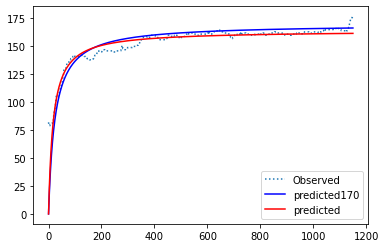

In [87]:
training_session='training-session-2021-06-16-6165494184-d5e56939-967d-4453-9bbd-047e093ffb58.json'
obs_x_y=polar_obs_var_dict[training_session]
predicted_y=polar_pred_var_dict[training_session]

plt.plot(obs_x_y[0], obs_x_y[1],':', label='Observed')
plt.plot(obs_x_y[0],predicted_y[2],'b-', label='predicted170')
plt.plot(obs_x_y[0],predicted_y[0],'r-', label='predicted')
plt.legend(loc='best')
plt.show()

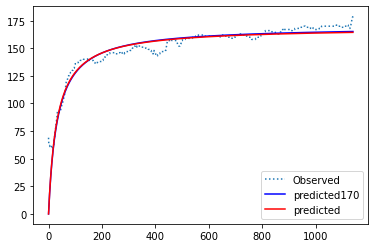

In [88]:
training_session='training-session-2021-06-09-6138612989-d290224e-957b-4503-8cef-a889c62e4718.json'
obs_x_y=polar_obs_var_dict[training_session]
predicted_y=polar_pred_var_dict[training_session]

plt.plot(obs_x_y[0], obs_x_y[1],':', label='Observed')
plt.plot(obs_x_y[0],predicted_y[2],'b-', label='predicted170')
plt.plot(obs_x_y[0],predicted_y[0],'r-', label='predicted')
plt.legend(loc='best')
plt.show()

In [92]:
obs_x_y[1][:30]

array([69, 63, 62, 62, 62, 61, 61, 60, 60, 60, 61, 61, 62, 62, 61, 60, 60,
       60, 60, 62, 65, 67, 69, 71, 73, 75, 77, 79, 81, 83])